# Projet Machine Learning
- Bruno Dumas (p1100740)
- Romy Ratolojanahary (p1210599)

## Présentation du sujet

Le sujet de ce projet est proposé sur le site Kaggle par le site Quora. Il s'agit d'un forum de questions-réponses sur tous les sujets.
Quora désire identifier les questions dupliquées. Le dataset contient des paires de questions.
Le but du projet est donc de définir si deux questions sont similaires ou non.

Les données sont téléchargeables à l'url suivante : https://www.kaggle.com/c/quora-question-pairs/data 

In [1]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import nltk

from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

for lib in ['stopwords', 'wordnet', 'punkt', 'maxent_treebank_pos_tagger', 'averaged_perceptron_tagger']: 
    nltk.download(lib)

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/bruno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/bruno/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bruno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# On importe les données
quora = pd.read_csv('./train.csv', delimiter=',')

# Réduction de la taille de la base pour accélérer les traitements
from sklearn.model_selection import train_test_split
quora, _ = train_test_split(quora, test_size = 0.9)
quora = quora.sort()

In [3]:
quora.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
16,16,33,34,What does manipulation mean?,What does manipulation means?,1
19,19,39,40,Which is the best digital marketing institutio...,Which is the best digital marketing institute ...,0
21,21,43,44,What's causing someone to be jealous?,What can I do to avoid being jealous of someone?,0
27,27,55,56,Does society place too much importance on sports?,How do sports contribute to the society?,0
31,31,63,64,What are some special cares for someone with a...,How can I keep my nose from getting stuffy at ...,1
37,37,75,76,"When a girlfriend asks her boyfriend ""Why did ...",My girlfriend said that we should end this bec...,0
38,38,77,78,How do we prepare for UPSC?,How do I prepare for civil service?,1
56,56,113,114,Who is israil friend?,Is my boyfriend lying about his true feelings ...,0
59,59,119,120,What are the best ways to learn French?,How do I learn french genders?,0
70,70,141,142,What are the types of immunity?,What are the different types of immunity in ou...,0


## Statistique Descriptive

Chaque observation comporte 2 paires de questions. Les autres colonnes sont l'id de l'observation, l'id de la question 1, l'id de la question 2 et enfin un booléen 'is_duplicate' qui vaut 1 si les questions sont similaires, 0 sinon.

n_obs  = 40429
n_obs sans duplicats  = 40429
n_obs sans NA  = 40429
is_duplicate
0    25461
1    14968
dtype: int64


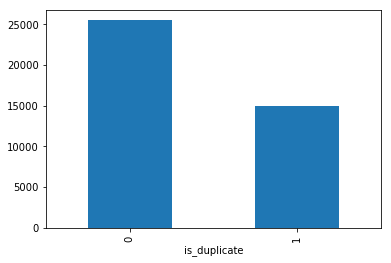

In [4]:
# Nombre de paires de questions
n_obs = quora.shape[0]
print("n_obs  = %d" %n_obs)

# On enlève les duplicats (les paires qui sont présentes plus d'une fois) 
quora.drop_duplicates(inplace=True)
n_obs1 = quora.shape[0]
print("n_obs sans duplicats  = %d" %n_obs1)

# On enlève les lignes contenant des NaN

quora.dropna(inplace=True) 
n_obs2 = quora.shape[0]
print("n_obs sans NA  = %d" %n_obs2)

# Proportion de 0 et de 1
print(quora.groupby(['is_duplicate']).size())
quora.groupby(['is_duplicate']).size().plot.bar()
plt.show()

## Préparation des données

In [5]:
# Ajouter une colonne tokens qui contient les mots tokenisés
quora['tokens1'] = quora.question1.apply(lambda x: (nltk.word_tokenize(x)))
quora['tokens2'] = quora.question2.apply(lambda x: (nltk.word_tokenize(x)))

In [6]:
# On détermine la nature grammaticale des mots 
quora['tokenspos1'] = quora.tokens1.apply(lambda x: nltk.pos_tag(x))
quora['tokenspos2'] = quora.tokens2.apply(lambda x: nltk.pos_tag(x))

In [7]:
from nltk.stem import WordNetLemmatizer

# Fonction qui retourne la 'racine' du mot
# Si c'est un nom, renvoyer nom générique (singulier), si verbe, renvoyer l'infinitif

def lemmatizer(sentence): # Entrée de la forme [(mot1,tag1),(mot2,tag2)....]
    wordnet_lemmatizer = WordNetLemmatizer()
    posVerb = []
    for t in sentence:
        if t[1][0] == 'V':
            posVerb.append(wordnet_lemmatizer.lemmatize(t[0],pos='v'))
        else:
            posVerb.append(wordnet_lemmatizer.lemmatize(t[0]))
    return posVerb    
                           
quora['lemma1'] = quora.tokenspos1.apply(lambda x: lemmatizer(x))
quora['lemma2'] = quora.tokenspos2.apply(lambda x: lemmatizer(x))

In [8]:
quora[['question1','question2','lemma1','lemma2']].head(10)

,question1,question2,lemma1,lemma2
16,What does manipulation mean?,What does manipulation means?,"[What, do, manipulation, mean, ?]","[What, do, manipulation, mean, ?]"
19,Which is the best digital marketing institutio...,Which is the best digital marketing institute ...,"[Which, be, the, best, digital, marketing, ins...","[Which, be, the, best, digital, marketing, ins..."
21,What's causing someone to be jealous?,What can I do to avoid being jealous of someone?,"[What, 's, cause, someone, to, be, jealous, ?]","[What, can, I, do, to, avoid, be, jealous, of,..."
27,Does society place too much importance on sports?,How do sports contribute to the society?,"[Does, society, place, too, much, importance, ...","[How, do, sport, contribute, to, the, society, ?]"
31,What are some special cares for someone with a...,How can I keep my nose from getting stuffy at ...,"[What, be, some, special, care, for, someone, ...","[How, can, I, keep, my, nose, from, get, stuff..."
37,"When a girlfriend asks her boyfriend ""Why did ...",My girlfriend said that we should end this bec...,"[When, a, girlfriend, ask, her, boyfriend, ``,...","[My, girlfriend, say, that, we, should, end, t..."
38,How do we prepare for UPSC?,How do I prepare for civil service?,"[How, do, we, prepare, for, UPSC, ?]","[How, do, I, prepare, for, civil, service, ?]"
56,Who is israil friend?,Is my boyfriend lying about his true feelings ...,"[Who, be, israil, friend, ?]","[Is, my, boyfriend, lie, about, his, true, fee..."
59,What are the best ways to learn French?,How do I learn french genders?,"[What, be, the, best, way, to, learn, French, ?]","[How, do, I, learn, french, gender, ?]"
70,What are the types of immunity?,What are the different types of immunity in ou...,"[What, be, the, type, of, immunity, ?]","[What, be, the, different, type, of, immunity,..."


In [9]:
import string

# Retrait des stopwords des questions

stopwords = nltk.corpus.stopwords.words('english')

# Nous allons retirer quelques stopwords et ajouter les signes de ponctuation
remove_words = ['not', 't', 'why', 'when', 'who', 'which', 'where', 'what', 'how', 'i', 'me', 
                'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
                'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
                'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves']
add_words = []
add_words.extend([char for char in string.punctuation])
for w in remove_words:
    stopwords.remove(w)
for w in add_words:
    stopwords.append(w)

def remove_stopwords(sentence):
    out = []
    for t in sentence:
        if t.lower() not in stopwords:
            out.append(t.lower())
    return out


quora['q1'] = quora.lemma1.apply(lambda x: remove_stopwords(x))
quora['q2'] = quora.lemma2.apply(lambda x: remove_stopwords(x))


In [10]:
# Affichage des questions contenant le moins de mots-clés
# La plupart ne sont pas valides
ids = quora["id"]

for i in ids:
    if len(quora["q1"][i]) <= 1:
        print(i, quora["q1"][i], quora["question1"][i])

17682 ['delete'] deleted
35641 ['what'] What to do ?
102512 ['ok'] ok ?
104101 [] ?
106577 ['what'] What?
109311 ['what'] What
189659 [] ?
205947 ['deleted'] Deleted.
216861 ['aaas'] Aaas
249633 ['scabies'] Is this scabies?
325200 ['error'] Error
326297 ['how'] How
356434 ['deleted'] Deleted.
369529 ['who'] Who is the?


In [11]:
# Nombre de mots-clés de chaque question et différence entre les 2
quora['lenq1'] = quora.q1.apply(lambda x: len(x))
quora['lenq2'] = quora.q2.apply(lambda x: len(x))
quora['diff'] = quora['lenq1'] - quora['lenq2'] 

In [12]:
# Nombre de mots-clés en commun
def words_in_common(list1, list2):
    if len(list1)<len(list2):
        l1 = list1
        l2 = list2
    else:
        l1 = list2
        l2 = list1
    n = 0
    for word in l1:
        if word in l2:
            n += 1
    return n

quora['nb_common_words'] = quora.apply(lambda x:words_in_common(x['q1'], x['q2']), axis=1)

In [13]:
# Ratio nombre de mots communs / nombre total de mots pour chaque liste de mots-clés
def ratio_common_words(n, nt):
    if nt == 0: # Si la question contient uniquement des stopwords
        return 0
    else:
        return n/nt
    
quora['ratio_cw_q1'] = quora.apply(lambda x:ratio_common_words(x['nb_common_words'], x['lenq1']), axis=1)
quora['ratio_cw_q2'] = quora.apply(lambda x:ratio_common_words(x['nb_common_words'], x['lenq2']), axis=1)


n_obs_train  = 32343
is_duplicate
0    20431
1    11912
dtype: int64


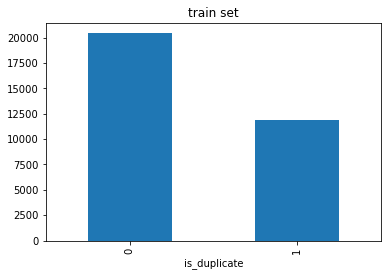

In [29]:
# On va d'abord diviser notre base de données en une base d'apprentissage et une base de test

from sklearn.model_selection import train_test_split
train, test = train_test_split(quora, test_size = 0.2)

# Nombre de paires de questions
n_obs_train = train.shape[0]
print("n_obs_train  = %d" %n_obs_train)

# Proportion de 0 et de 1
print(train.groupby(['is_duplicate']).size())
train.groupby(['is_duplicate']).size().plot.bar(title='train set')
plt.show()


n_obs_test  = 8086
is_duplicate
0    5030
1    3056
dtype: int64


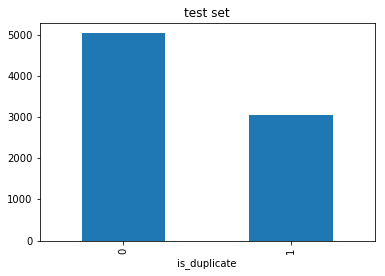

In [30]:
# Nombre de paires de questions
n_obs_test = test.shape[0]
print("n_obs_test  = %d" %n_obs_test)

# Proportion de 0 et de 1
print(test.groupby(['is_duplicate']).size())
test.groupby(['is_duplicate']).size().plot.bar(title='test set')
plt.show()


## Transformation des questions en vecteurs numériques

In [31]:
import gensim
from gensim import corpora

def vectoriser(table):
    dictionary = corpora.Dictionary(quora['q1'].tolist() + quora['q2'].tolist())
    # On crée un vecteur contenant le nombre d'occurrences de chaque mot du dictionnaire pour chaque question
    vecteur1 = [dictionary.doc2bow(text) for text in table["q1"]]
    vecteur2 = [dictionary.doc2bow(text) for text in table["q2"]]
    return vecteur1, vecteur2

In [32]:
from gensim import models, similarities

# Distance cosinus entre les 2 vecteurs
vecteur1, vecteur2 = vectoriser(train)
train['vecteur1'] = vecteur1
train['vecteur2'] = vecteur2
train['cosinus_dist'] = train.apply(lambda x:gensim.matutils.cossim(x['vecteur1'], x['vecteur2']), axis=1)


t_vecteur1, t_vecteur2 = vectoriser(test)
test['vecteur1'] = t_vecteur1
test['vecteur2'] = t_vecteur2
test['cosinus_dist'] = test.apply(lambda x:gensim.matutils.cossim(x['vecteur1'], x['vecteur2']), axis=1)

In [33]:
# Calcul du score TF-IDF score pour chaque mot

corpora.MmCorpus.serialize('corpus.mm', vecteur1 + vecteur2) # Sauvegarder le corpus
corpus1 = corpora.MmCorpus('corpus.mm') # Charger le corpus

corpora.MmCorpus.serialize('t_corpus.mm', t_vecteur1 + t_vecteur2) # Sauvegarder le corpus
t_corpus1 = corpora.MmCorpus('t_corpus.mm') # Charger le corpus

In [34]:
tfidf = models.TfidfModel(corpus1)

t_tfidf = models.TfidfModel(t_corpus1)

In [35]:
# Exemple vecteur en utilisant le score tfidf
corpus_tfidf = tfidf[vecteur1[0]]
print(corpus_tfidf)

[(38, 0.1310898006489969), (62, 0.2433340485605278), (1032, 0.42482912385939764), (1113, 0.5644892055182107), (1858, 0.6515183476704434)]


In [36]:
train['vecteur1_Tfidf'] = train.vecteur1.apply(lambda x: tfidf[x])
train['vecteur2_Tfidf'] = train.vecteur2.apply(lambda x: tfidf[x])
train['cosinus_dist_Tfidf'] = train.apply(
    lambda x:gensim.matutils.cossim(x['vecteur1_Tfidf'], x['vecteur2_Tfidf']), axis=1)

test['vecteur1_Tfidf'] = test.vecteur1.apply(lambda x: t_tfidf[x])
test['vecteur2_Tfidf'] = test.vecteur2.apply(lambda x: t_tfidf[x])
test['cosinus_dist_Tfidf'] = test.apply(
    lambda x:gensim.matutils.cossim(x['vecteur1_Tfidf'], x['vecteur2_Tfidf']), axis=1)


In [37]:
print(list(train.columns.values))
train[['question1', 'lemma1', 'q1', 'lenq1', 'diff', 'nb_common_words', 'ratio_cw_q1',
       'cosinus_dist', 'vecteur1_Tfidf', 'cosinus_dist_Tfidf']].head(5)

['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'tokens1', 'tokens2', 'tokenspos1', 'tokenspos2', 'lemma1', 'lemma2', 'q1', 'q2', 'lenq1', 'lenq2', 'diff', 'nb_common_words', 'ratio_cw_q1', 'ratio_cw_q2', 'vecteur1', 'vecteur2', 'cosinus_dist', 'vecteur1_Tfidf', 'vecteur2_Tfidf', 'cosinus_dist_Tfidf']


,question1,lemma1,q1,lenq1,diff,nb_common_words,ratio_cw_q1,cosinus_dist,vecteur1_Tfidf,cosinus_dist_Tfidf
220973,How hard is it to become a doctor?,"[How, hard, be, it, to, become, a, doctor, ?]","[how, hard, it, become, doctor]",5,-1,4,0.800000,0.790569,"[(38, 0.1310898006489969), (62, 0.243334048560...",0.897616
60724,Where can I get high quality promotional self-...,"[Where, can, I, get, high, quality, promotiona...","[where, i, get, high, quality, promotional, se...",11,0,7,0.636364,0.636364,"[(21, 0.12265613358890189), (86, 0.06549403059...",0.462982
169079,What are the most promising Silicon Valley sta...,"[What, be, the, most, promising, Silicon, Vall...","[what, promising, silicon, valley, startup, wa...",7,2,4,0.571429,0.676123,"[(0, 0.05598333847973518), (385, 0.30969722474...",0.591185
287163,"What is the cheapest, painless, easiest way to...","[What, be, the, cheapest, ,, painless, ,, easi...","[what, cheapest, painless, easiest, way, commi...",7,-3,4,0.571429,0.478091,"[(0, 0.06002708253502831), (45, 0.222452909300...",0.350045
21548,What are the best places to live if one has ar...,"[What, be, the, best, place, to, live, if, one...","[what, best, place, live, one, arthritis]",6,-2,3,0.500000,0.433013,"[(0, 0.07218989425514374), (4, 0.1878898640351...",0.310552


## Lancement des classifieurs

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_train = train["is_duplicate"]
X_train = train[["diff", "nb_common_words", "lenq1", "lenq2", "ratio_cw_q1", "ratio_cw_q2",
                 "cosinus_dist", "cosinus_dist_Tfidf"]]

y_test = test["is_duplicate"]
X_test = test[["diff", "nb_common_words", "lenq1", "lenq2", "ratio_cw_q1", "ratio_cw_q2",
               "cosinus_dist", "cosinus_dist_Tfidf"]]

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

### Random forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy = ", accuracy_score(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["not duplicate", "duplicate"]))

Accuracy =  0.670789018056
               precision    recall  f1-score   support

not duplicate       0.73      0.75      0.74      5030
    duplicate       0.57      0.54      0.55      3056

  avg / total       0.67      0.67      0.67      8086



### MLP

In [40]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16, 8), random_state=1)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("Accuracy = ", accuracy_score(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["not duplicate", "duplicate"]))

Accuracy =  0.717783823893
               precision    recall  f1-score   support

not duplicate       0.76      0.80      0.78      5030
    duplicate       0.64      0.58      0.61      3056

  avg / total       0.71      0.72      0.71      8086



### KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy = ", accuracy_score(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["not duplicate", "duplicate"]))

Accuracy =  0.708384862726
               precision    recall  f1-score   support

not duplicate       0.75      0.80      0.77      5030
    duplicate       0.63      0.55      0.59      3056

  avg / total       0.70      0.71      0.70      8086



### AdaBoost

In [42]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), algorithm="SAMME", n_estimators=50)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print("Accuracy = ", accuracy_score(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["not duplicate", "duplicate"]))

Accuracy =  0.707642839476
               precision    recall  f1-score   support

not duplicate       0.75      0.81      0.77      5030
    duplicate       0.63      0.55      0.59      3056

  avg / total       0.70      0.71      0.70      8086



## Analyse des résultats
Les différents classifieurs obtiennent des scores assez similaires. On a fait varier les paramètres pour optimiser les résultats.

On obtient des résultats substantiellement meilleurs en moyenne avec un réseau de neurones profond (MLP). Cependant, l'algorithme k-nearest neighbours offre une précision supérieure.

### Idées d'amélioration
- L'utilisation d'un dictionnaire de synonymes aurait pu améliorer les prédictions. En plus de compter le nombre de mots communs aux deux questions, on compte les mots synonymes.
- Utiliser d'autres outils de classification (comme XGBoost) qui donnent de bons résultats sur ce genre de problème.